In [1]:
#one level up into project folder
import os
%pwd


'/itf-fi-ml/home/arunps/Projects/VisionLLM_InteractionAnalysis/notebook'

In [2]:
os.chdir("..")

%pwd

'/itf-fi-ml/home/arunps/Projects/VisionLLM_InteractionAnalysis'

In [3]:
import yaml
import json
import random

import cv2
import matplotlib.pyplot as plt

In [4]:
def _load_manifest(manifest_path: str) -> dict:
    with open(manifest_path, "r", encoding="utf-8") as f:
        return yaml.safe_load(f)


def _load_coco(annotation_file: str):
    with open(annotation_file, "r", encoding="utf-8") as f:
        coco = json.load(f)

    # images: list of dicts (id, file_name, width, height, ...)
    images = coco["images"]

    # annotations: list of dicts (image_id, bbox, category_id, ...)
    annotations = coco["annotations"]

    # categories: list (id, name, supercategory)
    categories = coco["categories"]

    # Build helpful lookup tables
    cat_id_to_name = {c["id"]: c["name"] for c in categories}

    img_id_to_info = {img["id"]: img for img in images}

    ann_by_image_id = {}
    for ann in annotations:
        ann_by_image_id.setdefault(ann["image_id"], []).append(ann)

    return images, img_id_to_info, ann_by_image_id, cat_id_to_name


def imgshow_coco(
    manifest_path: str,
    split: str = "train",          # "train" or "val"
    index: int | None = None,      # pick the Nth image in the COCO images list
    image_id: int | None = None,   # OR pick a specific COCO image_id
    size: int = 7,
    title: str | None = None,
    show_labels: bool = True,
    max_boxes: int | None = None,  # e.g. 20 to limit clutter
    seed: int = 0,
):
    """
    Display a COCO image with bounding boxes using paths from data_manifest.yaml.
    Works for object detection (instances_*.json).

    Choose either:
      - index (0..len(images)-1), or
      - image_id (COCO image id)

    If both are None, it will pick a random image.
    """
    m = _load_manifest(manifest_path)

    # Read paths from manifest
    images_dir = m["paths"]["train_images"] if split == "train" else m["paths"]["val_images"]
    ann_file = m["annotations"]["train"] if split == "train" else m["annotations"]["val"]

    # Load COCO annotations
    images, img_id_to_info, ann_by_image_id, cat_id_to_name = _load_coco(ann_file)

    # Select image
    if image_id is None and index is None:
        random.seed(seed)
        chosen = random.choice(images)
        image_id = chosen["id"]
    elif image_id is None:
        if index < 0 or index >= len(images):
            raise ValueError(f"index out of range: {index} (0..{len(images)-1})")
        image_id = images[index]["id"]

    if image_id not in img_id_to_info:
        raise ValueError(f"image_id {image_id} not found in COCO annotation file: {ann_file}")

    img_info = img_id_to_info[image_id]
    file_name = img_info["file_name"]
    img_path = os.path.join(images_dir, file_name)

    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image file not found: {img_path}")

    # Read image
    image = cv2.imread(img_path)
    if image is None:
        raise RuntimeError(f"cv2 failed to read image: {img_path}")

    # Draw boxes
    anns = ann_by_image_id.get(image_id, [])
    if max_boxes is not None:
        anns = anns[:max_boxes]

    for ann in anns:
        # COCO bbox format: [x, y, width, height]
        x, y, w, h = ann["bbox"]
        x1, y1, x2, y2 = int(x), int(y), int(x + w), int(y + h)

        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

        if show_labels:
            cat_name = cat_id_to_name.get(ann["category_id"], str(ann["category_id"]))
            # Put label above box (simple)
            cv2.putText(
                image,
                cat_name,
                (x1, max(0, y1 - 5)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (0, 0, 255),
                2,
                cv2.LINE_AA,
            )

    # Plot
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    aspect_ratio = rgb.shape[0] / rgb.shape[1]
    plt.figure(figsize=(size + aspect_ratio, size))
    plt.imshow(rgb)

    n_boxes = len(anns)
    if title is None:
        plt.title(f"{split} | image_id={image_id} | {file_name} | boxes={n_boxes}")
    else:
        plt.title(f"{title} | boxes={n_boxes}")

    plt.axis("off")
    plt.show()


In [5]:
manifest_path = "artifacts/12_31_2025_16_10_10/data_ingestion/data_manifest.yaml"

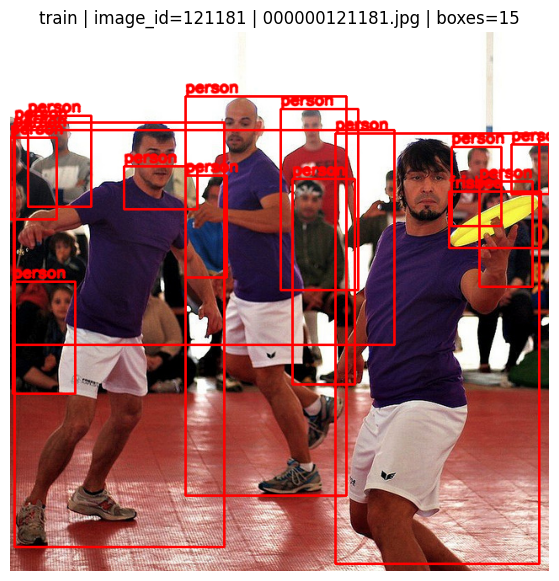

In [6]:
imgshow_coco(manifest_path, split="train")

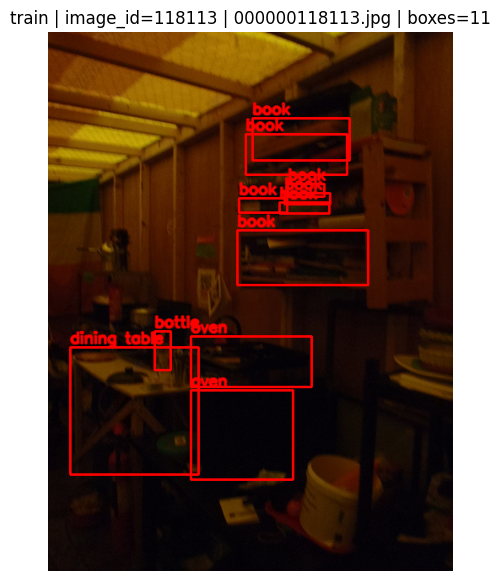

In [7]:
imgshow_coco(manifest_path, split="train", index=10)

In [8]:
import os
import json
from pathlib import Path

import cv2
import yaml
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm.auto import tqdm


# ----------------------------
# Utils
# ----------------------------
def load_manifest(manifest_path: str) -> dict:
    with open(manifest_path, "r", encoding="utf-8") as f:
        return yaml.safe_load(f)


def collate_fn(batch):
    return tuple(zip(*batch))


# ----------------------------
# COCO Dataset for Detection
# ----------------------------
class COCODetectionFromManifest(Dataset):
    def __init__(self, images_dir: str, ann_file: str):
        self.images_dir = images_dir
        self.ann_file = ann_file

        with open(self.ann_file, "r", encoding="utf-8") as f:
            coco = json.load(f)

        self.images = coco["images"]
        self.annotations = coco["annotations"]
        self.categories = coco.get("categories", [])

        cat_ids = sorted({c["id"] for c in self.categories}) if self.categories else sorted({a["category_id"] for a in self.annotations})
        self.cat_id_to_contig = {cat_id: i + 1 for i, cat_id in enumerate(cat_ids)}

        self.img_id_to_info = {img["id"]: img for img in self.images}
        self.img_ids = [img["id"] for img in self.images]

        self.ann_by_img = {}
        for ann in self.annotations:
            self.ann_by_img.setdefault(ann["image_id"], []).append(ann)

        # remove images with no annotations
        self.img_ids = [img_id for img_id in self.img_ids if img_id in self.ann_by_img]

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx: int):
        image_id = self.img_ids[idx]
        info = self.img_id_to_info[image_id]
        img_path = os.path.join(self.images_dir, info["file_name"])

        image_bgr = cv2.imread(img_path)
        if image_bgr is None:
            raise FileNotFoundError(f"Failed to read image: {img_path}")

        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB).astype("float32") / 255.0
        image = torch.from_numpy(image_rgb).permute(2, 0, 1)  # CPU tensor

        anns = self.ann_by_img.get(image_id, [])
        boxes, labels, area, iscrowd = [], [], [], []

        for ann in anns:
            x, y, w, h = ann["bbox"]
            if w <= 1 or h <= 1:
                continue
            boxes.append([x, y, x + w, y + h])
            labels.append(self.cat_id_to_contig[ann["category_id"]])
            area.append(float(ann.get("area", w * h)))
            iscrowd.append(int(ann.get("iscrowd", 0)))
            
        # force correct shapes even if empty
        boxes = torch.tensor(boxes, dtype=torch.float32).reshape(-1, 4)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([image_id], dtype=torch.int64),
            "area": torch.tensor(area, dtype=torch.float32),
            "iscrowd": torch.tensor(iscrowd, dtype=torch.int64),
        }
        return image, target



# ----------------------------
# Model wrapper
# ----------------------------
class FasterRCNNModel:
    def __init__(self, num_classes: int):
        """
        num_classes must include background.
        For COCO: 80 classes + background = 81
        """
        self.num_classes = num_classes
        self.model = self.create_model()

    def create_model(self):
        model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num_classes)
        return model

    def compile(self, optimizer):
        self.optimizer = optimizer

    def train_one_epoch(self, loader, device):
        self.model.train()
        running = 0.0

        pbar = tqdm(loader, desc="Train", leave=False)
        for images, targets in pbar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = self.model(images, targets)
            loss = sum(v for v in loss_dict.values())

            self.optimizer.zero_grad(set_to_none=True)
            loss.backward()
            self.optimizer.step()

            loss_val = float(loss.detach().cpu())
            running += loss_val
            pbar.set_postfix(loss=loss_val)

        return running / max(len(loader), 1)

    @torch.no_grad()
    def validate_one_epoch(self, loader, device):
        self.model.train()  
        running = 0.0

        pbar = tqdm(loader, desc="Val", leave=False)
        for images, targets in pbar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = self.model(images, targets)
            loss = sum(v for v in loss_dict.values())

            loss_val = float(loss.detach().cpu())
            running += loss_val
            pbar.set_postfix(loss=loss_val)

        return running / max(len(loader), 1)


/itf-fi-ml/home/arunps/Projects/VisionLLM_InteractionAnalysis/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# ----------------------------
# Main training cell / script
# ----------------------------
# manifest file
manifest_path =  "artifacts/12_31_2025_16_10_10/data_ingestion/data_manifest.yaml"

# 2) device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 3) Load manifest paths
m = load_manifest(manifest_path)

train_images_dir = m["paths"]["train_images"]
val_images_dir = m["paths"]["val_images"]
train_ann = m["annotations"]["train"]
val_ann = m["annotations"]["val"]

# 4) Build datasets 
train_ds = COCODetectionFromManifest(train_images_dir, train_ann)
val_ds = COCODetectionFromManifest(val_images_dir, val_ann)

img, tgt = train_ds[0]
print(img.shape, tgt["boxes"].shape, tgt["labels"].shape)

# 5) Dataloaders
train_loader = DataLoader(
    train_ds,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn,
    pin_memory=(device.type == "cuda"),
)

val_loader = DataLoader(
    val_ds,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn,
    pin_memory=(device.type == "cuda"),
)


# 6) Model
# COCO: 80 categories + background = 81
num_classes = 81
rcnn = FasterRCNNModel(num_classes=num_classes)
model = rcnn.model.to(device)

# 7) Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
rcnn.compile(optimizer)

# 8) Train loop
num_epochs = 6

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss = rcnn.train_one_epoch(train_loader, device)
    val_loss = rcnn.validate_one_epoch(val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")

print("\nDone.")


Using device: cuda


/tmp/ipykernel_3658933/3238854121.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "boxes": torch.tensor(boxes, dtype=torch.float32),
/tmp/ipykernel_3658933/3238854121.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(labels, dtype=torch.int64),


torch.Size([3, 360, 640]) torch.Size([4, 4]) torch.Size([4])


/itf-fi-ml/home/arunps/Projects/VisionLLM_InteractionAnalysis/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")



Epoch 1/6


Train loss: 0.6882 | Val loss: 0.6836

Epoch 2/6


Train loss: 0.6199 | Val loss: 0.6556

Epoch 3/6


Train loss: 0.5973 | Val loss: 0.6433

Epoch 4/6


Train loss: 0.5886 | Val loss: 0.6310

Epoch 5/6


Train loss: 0.5866 | Val loss: 0.6436

Epoch 6/6


Train:  88%|████████▊ | 25810/29317 [4:04:32<31:49,  1.84it/s, loss=0.733]   